# Bioinformatics: project no. 2
## CpG islands and DNA methylation analysis
## Autor: Jadwiga Słowik

In [1]:
import pandas as pd
import pybedtools

## Task 1:
Prepare files with coordinates of CpG islands, Shores, Shelves and Seas in BED format (chrN \t start \t end). Remember to consider chromosome boundaries. Please use only autosomal chromosomes

In [2]:
bed_col_names = ["chr", "start", "end"]

In [3]:
autosomal_chromosomes = ["chr{}".format(i) for i in range(1, 23)]
print(autosomal_chromosomes)

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']


### Prepare coordinates of CpG islands in BED format

In [4]:
cpg_islands_df = pybedtools.BedTool("data/cpgIslandExt.txt.gz") \
    .to_dataframe(header=None,
                  usecols=range(1, len(bed_col_names)+1),
                  names=bed_col_names)
cpg_islands_df = cpg_islands_df[cpg_islands_df.chr.isin(autosomal_chromosomes)]
print(cpg_islands_df.head())

    chr   start     end
0  chr1   28735   29810
1  chr1  135124  135563
2  chr1  327790  328229
3  chr1  437151  438164
4  chr1  449273  450544


/home/slowik/.local/lib/python3.5/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


In [5]:
print(cpg_islands_df.chr.unique())

['chr1' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17'
 'chr18' 'chr19' 'chr2' 'chr20' 'chr21' 'chr22' 'chr3' 'chr4' 'chr5'
 'chr6' 'chr7' 'chr8' 'chr9']


In [6]:
cpg_islands = pybedtools.BedTool.from_dataframe(cpg_islands_df).sort()
cpg_islands.saveas("./results/cpg_for_autosomal_chr.bed")

<BedTool(./results/cpg_for_autosomal_chr.bed)>

### Get chromosomes' sizes

In [7]:
chr22_sizes_path = "./results/chr22_sizes" 
chr_sizes_path = "./data/hg19.chrom.sizes"
chr_sizes_df = pd.read_csv(chr_sizes_path, sep="\t", header=None, names=["chr", "size"])
chr_sizes_df = chr_sizes_df[chr_sizes_df.chr.isin(autosomal_chromosomes)] \
    .sort_values(by=["chr"])
print(chr_sizes_df)
chr_sizes_df.to_csv(chr22_sizes_path, sep="\t", header=None, index=False)

      chr       size
0    chr1  249250621
10  chr10  135534747
11  chr11  135006516
12  chr12  133851895
13  chr13  115169878
14  chr14  107349540
15  chr15  102531392
16  chr16   90354753
17  chr17   81195210
18  chr18   78077248
21  chr19   59128983
1    chr2  243199373
19  chr20   63025520
23  chr21   48129895
22  chr22   51304566
2    chr3  198022430
3    chr4  191154276
4    chr5  180915260
5    chr6  171115067
6    chr7  159138663
8    chr8  146364022
9    chr9  141213431


### Prepare CpG shores in BED format

In [8]:
shore_length = 2000
cpg_shores = cpg_islands \
    .flank(b=shore_length, g=chr22_sizes_path) \
    .subtract(cpg_islands) \
    .sort() \
    .merge()
print(cpg_shores.head())
cpg_shores.saveas("./results/cpg_shores.bed")

chr1	26735	28735
 chr1	29810	31810
 chr1	133124	135124
 chr1	135563	137563
 chr1	325790	327790
 chr1	328229	330229
 chr1	435151	437151
 chr1	438164	440164
 chr1	447273	449273
 chr1	450544	452544
 None


<BedTool(./results/cpg_shores.bed)>

### Compute CpG shelves in BED format

In [25]:
shelve_length = 2000
cpg_shelves = cpg_islands \
    .slop(b=shore_length, g=chr22_sizes_path) \
    .flank(b=shelve_length, g=chr22_sizes_path) \
    .subtract(cpg_shores) \
    .subtract(cpg_islands) \
    .sort() \
    .merge()
print(cpg_shelves.head())
cpg_shelves.saveas("./results/cpg_shelves.bed")

chr1	24735	26735
 chr1	31810	33810
 chr1	131124	133124
 chr1	137563	139563
 chr1	323790	325790
 chr1	330229	332229
 chr1	433151	435151
 chr1	440164	442164
 chr1	445273	447273
 chr1	452544	454544
 None


<BedTool(./results/cpg_shelves.bed)>

### Compute CpG seas in BED format

In [27]:
non_sea_length_offset = shore_length + shelve_length
cpg_seas = cpg_islands \
    .slop(b=non_sea_length_offset, g=chr22_sizes_path) \
    .sort() \
    .complement(g=chr22_sizes_path) \
    .sort()
print(cpg_seas.head())
cpg_seas.saveas("./results/cpg_seas.bed")

chr1	0	24735
 chr1	33810	131124
 chr1	139563	323790
 chr1	332229	433151
 chr1	442164	445273
 chr1	454544	529219
 chr1	538114	540738
 chr1	550649	709984
 chr1	718547	758416
 chr1	767445	784863
 None


<BedTool(./results/cpg_seas.bed)>

## Task 2:
Set DNA Methylation coordinates as the middle of its range

In [11]:
dna_methylation_coords_df = pybedtools.BedTool("./data/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed.gz") \
    .to_dataframe(header=None,
                 usecols=range(0, 3),
                 names=bed_col_names)
dna_methylation_coords_df = dna_methylation_coords_df[dna_methylation_coords_df["chr"].isin(autosomal_chromosomes)] \
    .sort_values(by=["chr", "start"])

/home/slowik/.local/lib/python3.5/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


In [12]:
dna_methylation_coords_df["start"] = dna_methylation_coords_df.apply(
    lambda row: int(row["start"] + (row["end"] - row["start"]) / 2),
    axis=1)
dna_methylation_coords_df["end"] = dna_methylation_coords_df.apply(
    lambda row: row["start"] + 1,
    axis=1)
dna_methylation_coords_df.sort_values(by=["chr", "start"], inplace=True)
dna_methylation_coords_df.head()

,chr,start,end
256612,chr1,15890,15891
259522,chr1,18852,18853
225316,chr1,29432,29433
372828,chr1,29450,29451
8075,chr1,29460,29461


In [13]:
dna_methylation_cpg_path = "./results/dna_methylation_cpg"
dna_methylation_coords_df.to_csv(dna_methylation_cpg_path, sep="\t", header=None)

### Task 3
Find how many DNA Methylations are located in CpG islands, Shores, Shelves and Seas and show results using chart with information about percentage and number of methylations in regions (bar plot, pie... - you can use matplotlib, seaborn, bokeh..)

In [14]:
dna_methylation = pybedtools.BedTool.from_dataframe(dna_methylation_coords_df).sort()
print(dna_methylation.head())

chr1	15890	15891
 chr1	18852	18853
 chr1	29432	29433
 chr1	29450	29451
 chr1	29460	29461
 chr1	68874	68875
 chr1	69616	69617
 chr1	91575	91576
 chr1	135277	135278
 chr1	449101	449102
 None


In [15]:
regions = {
    "islands": {
        "data": cpg_islands
    },
    "shores": {
        "data": cpg_shores
    },
    "shelves": {
        "data": cpg_shelves
    },
    "seas": {
        "data": cpg_seas
    }
}

for region_name in regions.keys():
    regions[region_name]["hits"] = len(regions[region_name]["data"].intersect(dna_methylation))

all_hits = sum([regions[name]["hits"] for name in regions.keys()])

for region_name in regions.keys():
    regions[region_name]["hit_percentage"] = regions[region_name]["hits"] / all_hits

In [16]:
hits_df = pd.DataFrame(
    zip(regions.keys(),
        [regions[name]["hit_percentage"] for name in regions.keys()],
        [regions[name]["hits"] for name in regions.keys()]),
    columns=["region", "hits_perc", "hits"]
)
print(hits_df)

    region  hits_perc    hits
0   shores   0.261034  122913
1     seas   0.361896  170406
2  islands   0.280532  132094
3  shelves   0.096538   45457


### Bar plot

In [17]:
import matplotlib.pyplot as plt
import numpy as np

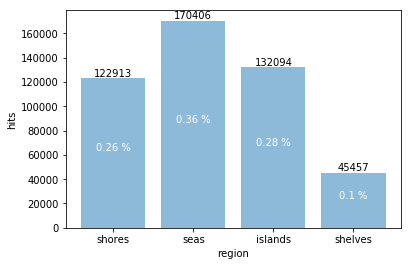

In [18]:
consecutive_nums = np.arange(hits_df.shape[0])
bar_plot = plt.bar(consecutive_nums, hits_df["hits"], align="center", alpha=0.5)
plt.xticks(consecutive_nums, hits_df["region"])
plt.ylabel("hits")
plt.xlabel("region")
for ind, bar in enumerate(bar_plot):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    hits_value = bar.get_height()
    hits_perc_value = "{} %".format(round(hits_df["hits_perc"][ind], 2))
    plt.text(x, y, hits_value, ha="center", va="bottom", rotation=0)
    plt.text(x, y / 2, hits_perc_value, ha="center", va="bottom", color="white")
plt.show()